In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nodepy.runge_kutta_method as rk

In [2]:
weights_lib = { 
                'Euler 1-step 1-order' : [1],
                'Euler 2-step 2-order' : [0.5 +0.5*1j, 0.5-0.5*1j],
                'Euler 2-step 3-order' : [1+1j*np.sqrt(2)/2,-1j*np.sqrt(2)/2],
                'Euler 2-step 3-order exp' : [0.838852+1j*0.604004, 0.161148-1j*0.604004],
                'Euler 2-step symplectic' : [0.5 +0.5*np.sqrt(3)*1j, 0.5-0.5*np.sqrt(3)*1j],
                'Euler 3-step 1-order' : [8.29344624e-01 , 5.95442650e-02, 1-8.29344624e-01-5.95442650e-02],
                'Euler 3-step 3-order' : [0.1867308533646 + 0.480773884550331*1j, 0.626538293270800, 0.1867308533646 - 0.480773884550331*1j],
                'Euler 3-step 2-order' : [0.411741936185254 + 0.430244574248458*1j, 0.176516127629493, 0.411741936185254-0.430244574248458*1j],
                'Euler 4-step 4-order' : [   0.04262665650273905+0.394632953172082*1j,
                                           0.4573733434973006-0.23510048799854047j, 0.4573733434973006+0.23510048799854047j, 0.04262665650273905-0.394632953172082*1j],
                'Euler 4-step 5-order' :[0.468161714486717 - 0.26941588085837*1j, 0.160647423722113 + 0.351192187389791*1j,0.335788810038662 + 0.241712151385474*1j, 0.0354020517525083 - 0.323488457916895*1j],
                'Euler 3-step 2-order better_ketch': [0.5667090896164737 - 0.20973993200649266*1j, 0.3027143968687541 + 0.5314020079354984*1j, 0.13057651351477217 - 0.32166207592900575*1j]
}



In [3]:
def pathwise(x, path):
    stepsize = x[1:]-x[:-1]
    contour = [x[0]]
    for i in range(len(x)-1):
        weights = np.cumsum(weights_lib[path])
        substeps = [x[i]+stepsize[i]*weight for weight in weights]
        contour +=substeps
    return np.array(contour)

In [4]:
class IVP(object):
    def __init__(self, f=None, u0=1., t0=0., T=1., exact=None, desc='', name=''):
        self.u0  = u0
        self.rhs = f
        self.T   = T
        self.exact = exact
        self.description = desc
        self.t0 = t0
        self.name = name
        


In [5]:
## Linear 
u0 = 1.
rhs = lambda t,u: u
exact = lambda t, u0=u0: u0*np.exp(t)
name = 'linear'
linear = IVP(f=rhs, u0=u0, T=5, exact = exact, name=name)

## simple harmonic motion y''=-y
u0 = np.array([0, 1])
rhs = lambda t,u: np.dot(np.matrix([[0, 1], [-1, 0] ]), u)
exact = lambda t, u0=u0: np.array([np.sin(t), np.cos(t)]).transpose()
name = 'shm'
shm = IVP(f=rhs, u0=u0, T=5, exact = exact, name=name)

## sqaure y''= y**2
u0 = 1
rhs = lambda t,u: -u**2
exact = lambda t, u0=u0: 1/(1+t)
name = 'square'
square = IVP(f=rhs, u0=u0, T=0.5, exact = exact, name=name)

## exp y''= e^y
u0 = 1
rhs = lambda t,u: -np.exp(u)
exact = lambda t, u0=u0: -np.log(t+np.exp(-1))
name = 'exp'
exponential = IVP(f=rhs, u0=u0, T = 1, exact = exact, name=name)


## 'nlsin'
u0 = 1.
rhs = lambda t,u: 4*u*np.sin(t)**3*np.cos(t)
exact = lambda t, u0=u0: u0*np.exp((np.sin(t))**4)
description = 'A simple nonlinear scalar problem'
name = 'nlsin'
nlsin = IVP(f=rhs, u0=u0, T=5., exact=exact, name=name)

#van der pol
eps = 0.1
u0 = np.array([2.,0])
rhs = lambda t,u: np.array([u[1], (1/eps)*((1-u[0]**2)*u[1])-u[0]])
vdp_jdg = IVP(f=rhs, u0=u0, T = 20, name = 'vdp')


def spec_diff(u, n = 1):
    N = len(u)
    k2 = np.zeros(N)
    if ((N%2)==0):
        #-even number                                                                                   
        for i in range(1,N//2):
            k2[i]=i
            k2[N-i]=-i
    else:
        #-odd number                                                                                    
        for i in range(1,(N-1)//2):
            k2[i]=i
            k2[N-i]=-i
    ik = (1j*k2)**n
    return np.fft.ifft(ik*np.fft.fft(u))



Nw = 80
x_dom = 2*np.pi*np.arange(0,Nw,1)/Nw
u_init1 = np.exp(-7*(x_dom-np.pi)**2)
u0 = u_init1
rhs = lambda t,u: -spec_diff(u)
exact1 = lambda t, u0=u0: np.array([np.exp(-7*(x_dom-np.pi -timepoint)**2) for timepoint in t])
print(len(exact1([0,1],u0)[0]))
name = 'wave'
wave = IVP(f=rhs, u0=u0, T = 1, exact = exact1, name = name)

N = 70
x = 2*np.pi*np.arange(0,N,1)/N
b = 1.5
visc = 0.1
u_init2 = 2*visc*np.sin(x)/(b+np.cos(x))
u0 = u_init2
rhs = lambda t,u: -0.5*spec_diff(u**2)+visc*spec_diff(u,2)
exact2 = lambda t, u0=u0: np.array([2*visc*np.exp(-visc*timepoint)*np.sin(x)/(b+np.exp(-visc*timepoint)*np.cos(x)) for timepoint in t])
name = 'burgers'
burgers = IVP(f=rhs, u0=u0, T = 2, exact = exact2, name = name)
print(len(wave.u0))

80
80


In [6]:
def convergence_test(timesteps, schemes, ode, exact_soln =[]):
    error_matrix = []
    for timestep in timesteps:
        end = ode.T
        t = np.linspace(0, end, int(end/timestep+1))
        if exact_soln ==[]:
            exact = ode.exact(t)
        else:
            print(int(timestep/exact_soln[1]), timestep/exact_soln[1])
            exact = np.array(exact_soln[0][::int(timestep/exact_soln[1])])
        
        scheme_error = []
        for scheme in schemes:
            path1 = pathwise(t, scheme)
            steps = path1[1:]-path1[:-1]
            if isinstance(ode.u0, (list, np.ndarray)):
                y1 = np.zeros((len(path1), len(ode.u0)), dtype = np.clongdouble)
            else:
                y1 = np.zeros((len(path1)), dtype = np.clongdouble)
            y1[0] = ode.u0
            #print(len(y1[0]))
            i = 1
            for step in steps:
                y1[i] = y1[i-1] + step*ode.rhs(path1[i-1], y1[i-1])
                if i%int(scheme[6])==0:
                    y1[i] = np.real(y1[i])
                i += 1
            scheme_error += [np.linalg.norm(y1[::int(scheme[6])]-exact, np.inf)]

        error_matrix.append(np.array(scheme_error))
    return np.array(error_matrix)

### Using odes from nodepy

In [173]:
import nodepy.runge_kutta_method as rk
import nodepy.convergence as cv
from nodepy import ivp


#IVP from nodepy
myivp = ivp.load_ivp('vdp')
#myivp.rhs =  lambda t,u: 4.*u*np.sin(t)**3*np.cos(t)
rk4 = rk.loadRKM('RK44')
timesteps = np.array([   0.0001,0.001, 0.004, 0.008, 0.01 ])
schemes = ['Euler 1-step 1-order', 'Euler 2-step 2-order', 'Euler 3-step 3-order','Euler 4-step 5-order', 'Euler 3-step 2-order', 'Euler 3-step 1-order']


rk4 = rk.loadRKM('RK44')
vdp_jdg.T = 20
t, u = rk4(vdp_jdg, dt = 0.01)rk4 = rk.loadRKM('RK44')
vdp_exact = u

### Convergence Plot

In [7]:
t = np.linspace(0, 1, 10)
path2 = pathwise(t, 'Euler 2-step 2-order')
path3 = pathwise(t, 'Euler 3-step 3-order')
odes = [linear, shm, square, exponential, vdp_jdg, wave, burgers]
print(burgers.name)
timesteps = [0.05,  0.01, 0.005, 0.0005]
schemes = ['Euler 1-step 1-order', 'Euler 2-step 2-order', 'Euler 3-step 3-order']

burgers


10000 10000.0
1000 1000.0000000000001
500 500.00000000000006
100 100.00000000000001
500 500.00000000000006


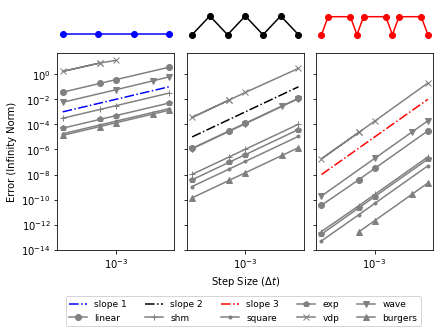

In [24]:
mosaic = """
    ABF
    CDE
    CDE
    CDE
    CDE
    CDE
    """
marker_lib = {
    'linear' : 'o', 
    'shm' : '+', 
    'square' : '.', 
    'exp' : 'p', 
    'nlsin' : 's',
    'wave' : 'v',
    'burgers' : '^',
    'vdp' : 'x'
    
}
timesteps_general = [0.01, 0.001,  0.0005, 0.0001 ]
timesteps_vdp = [.01, 0.001,  0.0005, 0.0001, 0.0005 ]#[0.05,  0.01, 0.001, 0.0001]
timesteps_burgers = [0.01, 0.005,0.001, 0.0005, 0.0001]
timesteps_wave = [ 0.01,0.005, 0.001, 0.0001 ]
t = np.linspace(0, 1, 4)
path2 = pathwise(t, 'Euler 2-step 2-order')
path3 = pathwise(t, 'Euler 3-step 3-order')
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)
ax_dict['D'].loglog([10**(-4), 10**(-2)], [10**(-5), 10**(-1)],'k-.', label = 'slope 2')
ax_dict['E'].loglog([10**(-4), 10**(-2)], [10**(-8), 10**(-2)],'r-.', label = 'slope 3')
ax_dict['C'].loglog([10**(-4), 10**(-2)], [0.001, 0.1],'b-.', label = 'slope 1')

for ode in odes:
    if ode.name == 'burgers':
        timesteps = timesteps_burgers
        er = convergence_test(timesteps, schemes, ode)
        ax_dict['E'].loglog(timesteps[:-1], er[:-1, 2], 'gray', marker=marker_lib[ode.name])
        ax_dict['C'].loglog(timesteps, er[:, 0], 'gray', label = ode.name, marker=marker_lib[ode.name])
    elif ode.name == 'wave':
        timesteps = timesteps_wave
        er = convergence_test(timesteps, schemes, ode)
        ax_dict['C'].loglog(timesteps, er[:, 0], 'gray', label = ode.name, marker=marker_lib[ode.name])
        ax_dict['E'].loglog(timesteps, er[:, 2], 'gray', marker=marker_lib[ode.name])
    elif ode.name =='vdp':
        timesteps = timesteps_vdp
        er = convergence_test(timesteps, schemes, ode, exact_soln = [vdp_exact, 0.000001])
        ax_dict['E'].loglog(timesteps, er[:, 2], 'gray', marker=marker_lib[ode.name])
        ax_dict['C'].loglog(timesteps[1:], er[1:, 0], 'gray', label = ode.name, marker=marker_lib[ode.name])
    else:
        timesteps = timesteps_general
        er = convergence_test(timesteps, schemes, ode)
        ax_dict['E'].loglog(timesteps, er[:, 2], 'gray', marker=marker_lib[ode.name])
        ax_dict['C'].loglog(timesteps, er[:, 0], 'gray', label = ode.name, marker=marker_lib[ode.name])
    ax_dict['D'].loglog(timesteps, er[:, 1], 'gray',  marker=marker_lib[ode.name])
    

ax_dict['C'].set_ylim([1e-14, 50])
ax_dict['D'].set_ylim([1e-14, 50])
ax_dict['E'].set_ylim([1e-14, 50])
ax_dict['D'].set_yticklabels([])
ax_dict['E'].set_yticklabels([])
ax_dict['A'].plot(t, np.zeros(len(t)) +0.23 , 'b-o')
ax_dict['A'].set_ylim([-1e-1, 1])
ax_dict['A'].axis('off')
ax_dict['B'].plot(path2.real, path2.imag , 'k-o')
ax_dict['B'].set_ylim([-1e-1, 0.25])
ax_dict['B'].axis('off')
ax_dict['F'].plot(path3.real, path3.imag , 'r-o')
ax_dict['F'].set_ylim([-1e-1, 0.25])
ax_dict['F'].axis('off')
ax_dict['C'].set_ylabel('Error (Infinity Norm)')
ax_dict['D'].set_xlabel('Step Size ' + r'($\Delta t$)',  fontsize = 10)


handle1, label1 = ax_dict['C'].get_legend_handles_labels()
handle2, label2 = ax_dict['D'].get_legend_handles_labels()
handle3, label3 = ax_dict['E'].get_legend_handles_labels()
labels = label1[0:2] +label2+[label1[2]]+label3+label1[3:]
handles = handle1[0:2] +handle2+[handle1[2]]+handle3+handle1[3:]

fig.legend(handles, labels, bbox_to_anchor=(0.975, 0), ncol =5, fontsize = 9)
plt.savefig('convergence_all_v2.pdf',bbox_inches="tight")